In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

# Tsukuba Modelling

### Loading in Tsukuba Dataset

In [10]:
tsukuba = pd.read_csv("data/tsukuba_ac.csv").iloc[:,:26]
tsukuba = tsukuba[tsukuba['P/W (hp/t)'] != '#DIV/0!']
tsukuba['P/W (hp/t)'] = tsukuba['P/W (hp/t)'].apply(np.float64)
tsukuba['Year'] = tsukuba['Year'].apply(np.float64)
tsukuba.dropna(axis=0, how='all', inplace=True)


def lt_in_seconds(time):
    minutes, seconds = time.strip().split(':')
    return 60*np.float64(minutes) + np.float64(seconds)

def msrp_float(msrp):
    if pd.isna(msrp):
        return np.float64(None)
    else:
        msrp = msrp.replace('$','').replace(',','').replace('>','')
        return np.float64(msrp)

tsukuba['MSRP (2022 USD)'] = tsukuba['MSRP (2022 USD)'].apply(msrp_float)

z='0:00.000'
tsukuba['Lap Time I']= tsukuba['Lap Time I'].fillna(z).apply(lt_in_seconds)
tsukuba['Lap Time II']= tsukuba['Lap Time II'].fillna(z).apply(lt_in_seconds)
tsukuba['Lap Time III']= tsukuba['Lap Time III'].fillna(z).apply(lt_in_seconds)

tsukuba_timed = (
    tsukuba.loc[tsukuba['Lap Time I'] > 0]
)

tsukuba_ac = tsukuba.loc[tsukuba['Source']!='irl']

tsukuba_all_irl = (
    tsukuba.loc[(tsukuba['Source']=='irl')]
    .drop(columns=['Author']))

tsukuba_irl = (
    tsukuba.loc[(tsukuba['Source']=='irl')&
                (tsukuba["compID"]==0)]
    .drop(columns=['Author']))

tsukuba_test_set = tsukuba.loc[tsukuba["compID"]>0]

tsukuba_test_set_irl = tsukuba_test_set.loc[tsukuba['Source']=='irl']

In [11]:
txt = " ({numcar} cars)"

print("Datasets:\n")
print("All Tsukuba Data"+txt.format(numcar = tsukuba.shape[0]))
display(tsukuba.head())
print("\nTimed  Data Only"+txt.format(numcar = tsukuba_timed.shape[0]))
display(tsukuba_timed.head())
print("\nAssetto Corsa Data"+txt.format(numcar = tsukuba_ac.shape[0]))
display(tsukuba_ac.head())
print("\nAll Real Life Data"+txt.format(numcar = tsukuba_all_irl.shape[0]))
display(tsukuba_all_irl.head())
print("\nReal Life Only Data"+txt.format(numcar = tsukuba_irl.shape[0]))
display(tsukuba_irl.head())
print("\nTest Set (Direct Comparisons)"+txt.format(numcar = tsukuba_test_set.shape[0]))
display(tsukuba_test_set.head())
print("\nTest Set (IRL)"+txt.format(numcar = tsukuba_test_set_irl.shape[0]))
display(tsukuba_test_set_irl.head())


Datasets:

All Tsukuba Data (1507 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Author,Source
0,1.0,0.0,2016.0,Abarth,124 Spider,0.000,NaN,NaN,0.000,NaN,...,271.0,1070.0,165.420561,FR,MT,NaN,2.0,L,?,link
1,2.0,1.0,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.000,NaN,...,206.0,1092.0,123.626374,FF,MT,NaN,3.0,L,Abarth,irl
2,3.0,1.0,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,...,205.0,1025.0,139.512195,FF,MT,3.5,3.0,L,Kunos,AC
3,4.0,0.0,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,...,252.0,1025.0,176.585366,FF,MT,3.0,3.0,L,Simaothekid,link
4,5.0,0.0,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,...,38.0,470.0,59.574468,RR,MT,3.0,3.0,L,Kunos,AC



Timed  Data Only (792 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Author,Source
1,2.0,1.0,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.000,NaN,...,206.0,1092.0,123.626374,FF,MT,NaN,3.0,L,Abarth,irl
2,3.0,1.0,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,...,205.0,1025.0,139.512195,FF,MT,3.5,3.0,L,Kunos,AC
3,4.0,0.0,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,...,252.0,1025.0,176.585366,FF,MT,3.0,3.0,L,Simaothekid,link
4,5.0,0.0,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,...,38.0,470.0,59.574468,RR,MT,3.0,3.0,L,Kunos,AC
5,6.0,0.0,2009.0,Abarth,Punto,71.601,0.0,NaN,0.000,NaN,...,230.0,1260.0,132.539682,FF,MT,3.5,3.0,L,Simaothekid,link



Assetto Corsa Data (1167 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Author,Source
0,1.0,0.0,2016.0,Abarth,124 Spider,0.000,NaN,NaN,0.000,NaN,...,271.0,1070.0,165.420561,FR,MT,NaN,2.0,L,?,link
2,3.0,1.0,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,...,205.0,1025.0,139.512195,FF,MT,3.5,3.0,L,Kunos,AC
3,4.0,0.0,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,...,252.0,1025.0,176.585366,FF,MT,3.0,3.0,L,Simaothekid,link
4,5.0,0.0,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,...,38.0,470.0,59.574468,RR,MT,3.0,3.0,L,Kunos,AC
5,6.0,0.0,2009.0,Abarth,Punto,71.601,0.0,NaN,0.000,NaN,...,230.0,1260.0,132.539682,FF,MT,3.5,3.0,L,Simaothekid,link



All Real Life Data (340 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WHP,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Source
1,2.0,1.0,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.0,NaN,...,135.0,206.0,1092.0,123.626374,FF,MT,NaN,3.0,L,irl
33,34.0,0.0,2001.0,Alfa Romeo,147 2.0 TS,77.860,0.0,NaN,0.0,NaN,...,129.0,158.0,1276.0,101.097179,FF,MT,NaN,3.0,R,irl
34,35.0,0.0,2005.0,Alfa Romeo,147 GTA,70.010,0.0,NaN,0.0,NaN,...,215.0,258.0,1394.0,154.232425,FF,MT,NaN,3.0,R,irl
40,41.0,0.0,2003.0,Alfa Romeo,156 GTA,72.900,0.0,NaN,0.0,NaN,...,242.0,277.0,1410.0,171.631206,RR,MT,NaN,4.0,L,irl
57,58.0,2.0,2017.0,Alpine,A110,65.040,0.0,NaN,0.0,NaN,...,234.0,317.0,1111.0,210.621062,MR,AT,NaN,2.0,L,irl



Real Life Only Data (171 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WHP,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Source
33,34.0,0.0,2001.0,Alfa Romeo,147 2.0 TS,77.860,0.0,NaN,0.0,NaN,...,129.0,158.0,1276.0,101.097179,FF,MT,NaN,3.0,R,irl
34,35.0,0.0,2005.0,Alfa Romeo,147 GTA,70.010,0.0,NaN,0.0,NaN,...,215.0,258.0,1394.0,154.232425,FF,MT,NaN,3.0,R,irl
40,41.0,0.0,2003.0,Alfa Romeo,156 GTA,72.900,0.0,NaN,0.0,NaN,...,242.0,277.0,1410.0,171.631206,RR,MT,NaN,4.0,L,irl
100,99.0,0.0,2003.0,Audi,A3 3.2 Quattro (8P),70.420,0.0,NaN,0.0,NaN,...,209.0,289.0,1565.0,133.546326,F4,AT,NaN,3.0,L,irl
122,121.0,0.0,2009.0,Audi,A6 3.0T Quattro (C6),71.153,0.0,NaN,0.0,NaN,...,234.0,344.0,1710.0,136.842105,F4,AT,NaN,4.0,L,irl



Test Set (Direct Comparisons) (384 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Author,Source
1,2.0,1.0,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.000,NaN,...,206.0,1092.0,123.626374,FF,MT,NaN,3.0,L,Abarth,irl
2,3.0,1.0,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,...,205.0,1025.0,139.512195,FF,MT,3.5,3.0,L,Kunos,AC
57,58.0,2.0,2017.0,Alpine,A110,65.040,0.0,NaN,0.000,NaN,...,317.0,1111.0,210.621062,MR,AT,NaN,2.0,L,Alpine,irl
58,59.0,2.0,2017.0,Alpine,A110 Premiere Ed.,64.444,0.0,NaN,0.000,NaN,...,290.0,1080.0,200.000000,MR,AT,4.5,2.0,L,Lucac26,Youtube
89,89.0,3.0,2006.0,Audi,R8 4.2 FSI,63.880,0.0,NaN,0.000,NaN,...,376.0,1604.0,220.698254,M4,AT,NaN,2.0,L,Audi,irl



Test Set (IRL) (169 cars)


,cID,compID,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,DR,_HD,Author,Source
1,2.0,1.0,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.0,NaN,...,206.0,1092.0,123.626374,FF,MT,NaN,3.0,L,Abarth,irl
57,58.0,2.0,2017.0,Alpine,A110,65.040,0.0,NaN,0.0,NaN,...,317.0,1111.0,210.621062,MR,AT,NaN,2.0,L,Alpine,irl
89,89.0,3.0,2006.0,Audi,R8 4.2 FSI,63.880,0.0,NaN,0.0,NaN,...,376.0,1604.0,220.698254,M4,AT,NaN,2.0,L,Audi,irl
92,92.0,4.0,2009.0,Audi,R8 V10 5.2 FSI,64.870,0.0,NaN,0.0,NaN,...,474.0,1671.0,290.245362,M4,AT,NaN,2.0,L,Audi,irl
94,94.0,5.0,2016.0,Audi,R8 V10 Plus,62.210,0.0,NaN,0.0,NaN,...,378.0,1637.0,314.599878,M4,AT,NaN,2.0,L,Audi,irl


In [22]:
assert tsukuba_ac.shape[0] + tsukuba_irl.shape[0] == tsukuba.shape[0]

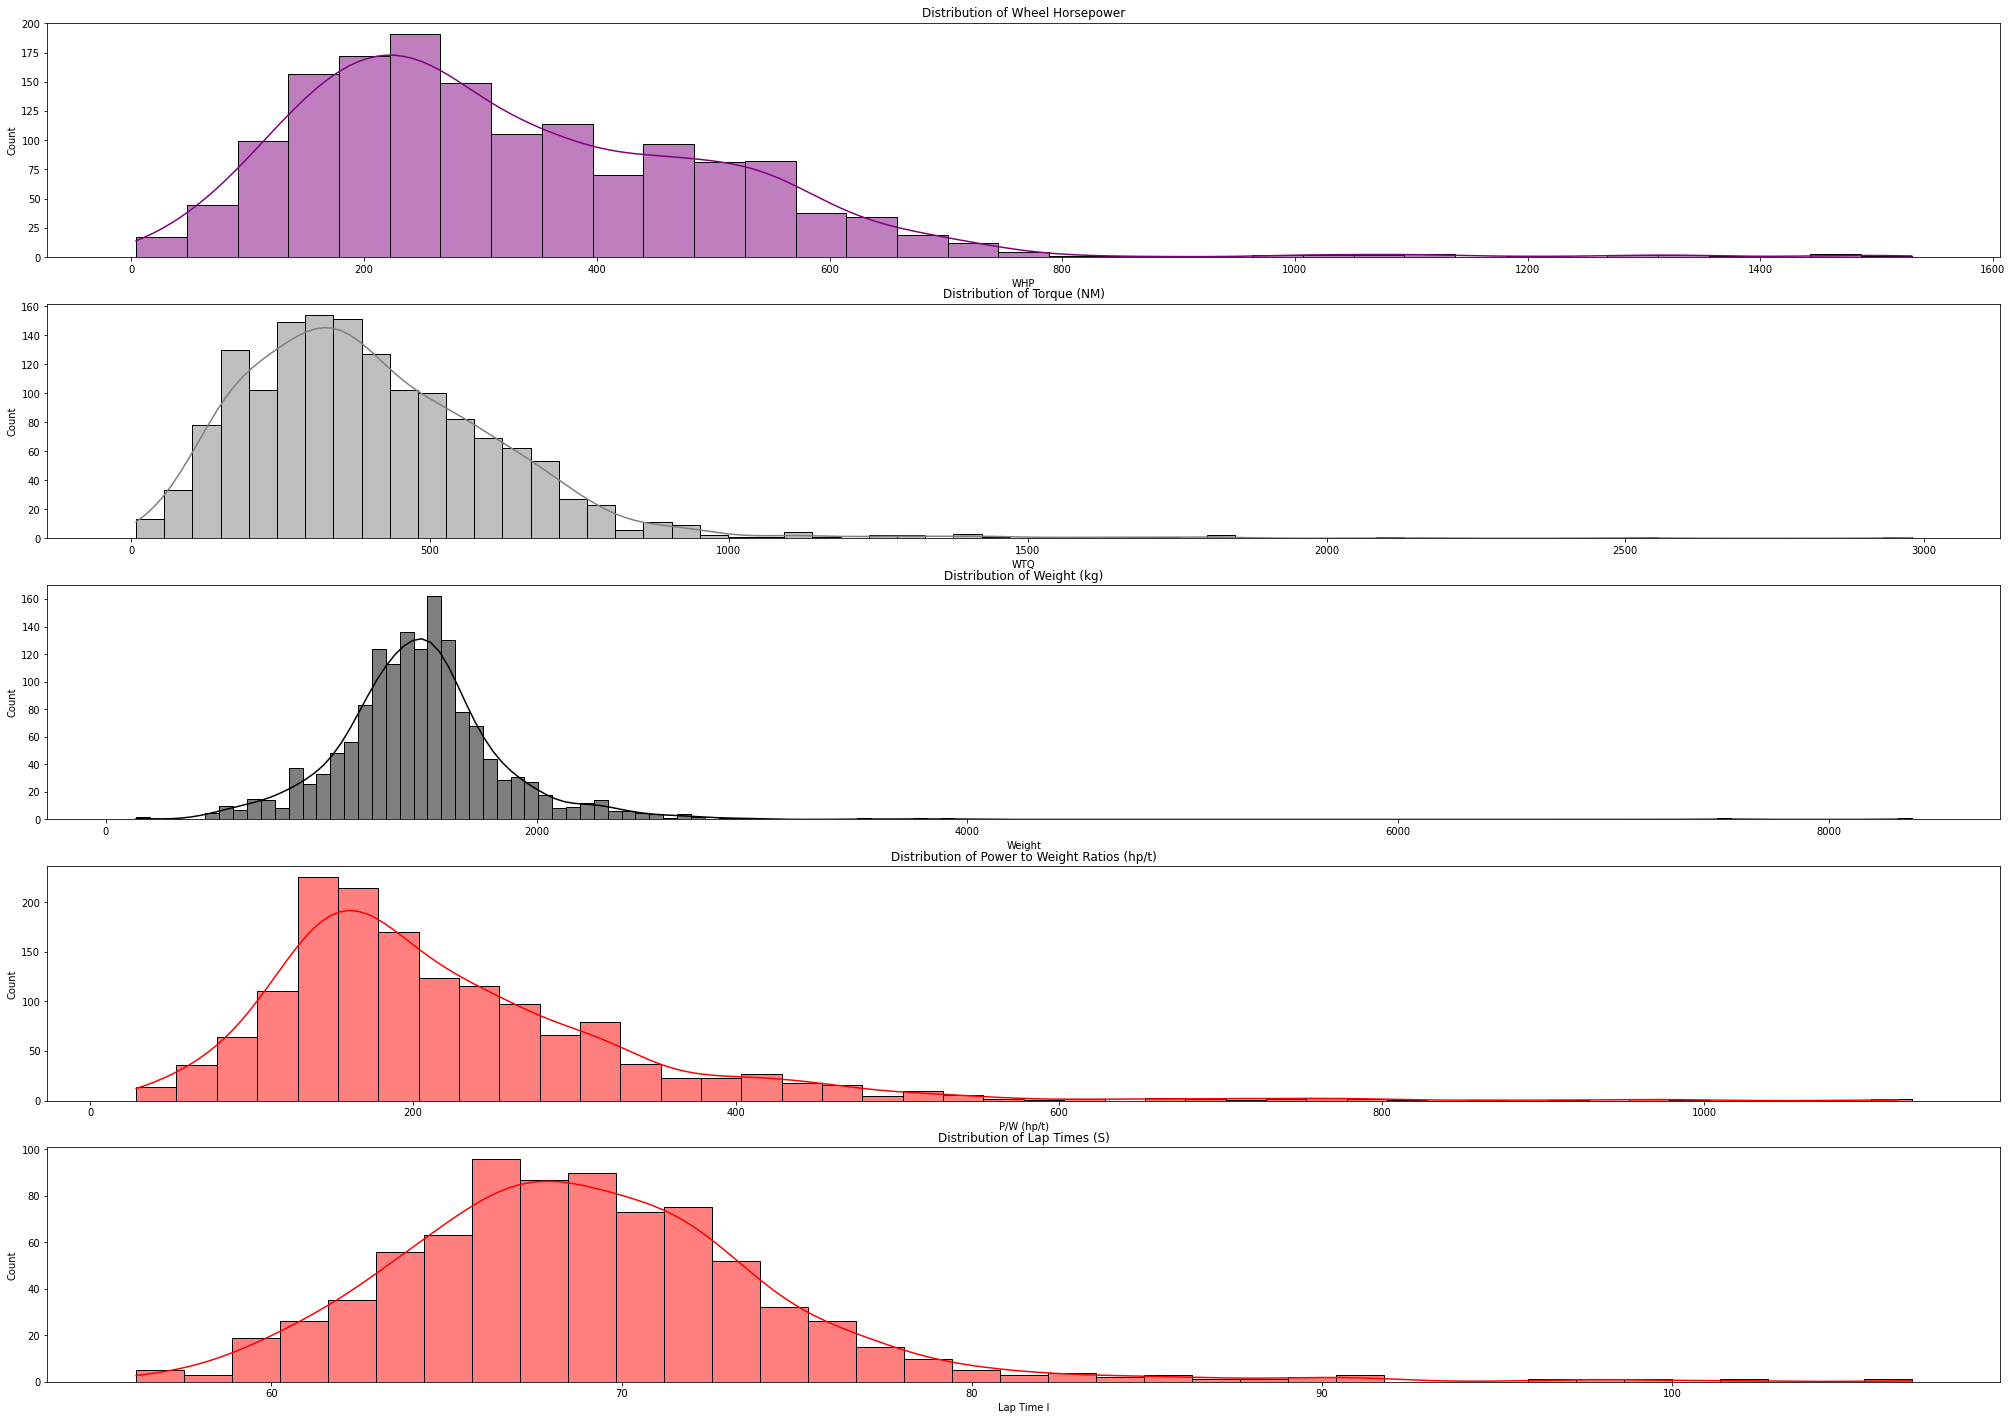

In [12]:
f, axes = plt.subplots(5, 1, figsize=(35,25),)

z = sns.histplot(
    data=tsukuba,
    x='WHP',
    ax=axes[0],
    color="purple",
    kde=True,
    ).set(title="Distribution of Wheel Horsepower")

z2 = sns.histplot(
    data=tsukuba,
    x='WTQ',
    ax=axes[1],
    color="grey",
    kde=True,
    ).set(title="Distribution of Torque (NM)")

z1 = sns.histplot(
    data=tsukuba,
    x='Weight',
    ax=axes[2],
    color="black",
    kde=True,
    ).set(title="Distribution of Weight (kg)")

y = sns.histplot(
    data=tsukuba,
    x='P/W (hp/t)',
    binwidth=25,
    ax=axes[3],
    color="red",
    kde=True,
    ).set(title="Distribution of Power to Weight Ratios (hp/t)")

y = sns.histplot(
    data=tsukuba_timed,
    x='Lap Time I',
    ax=axes[4],
    color="red",
    kde=True,
    ).set(title="Distribution of Lap Times (S)")

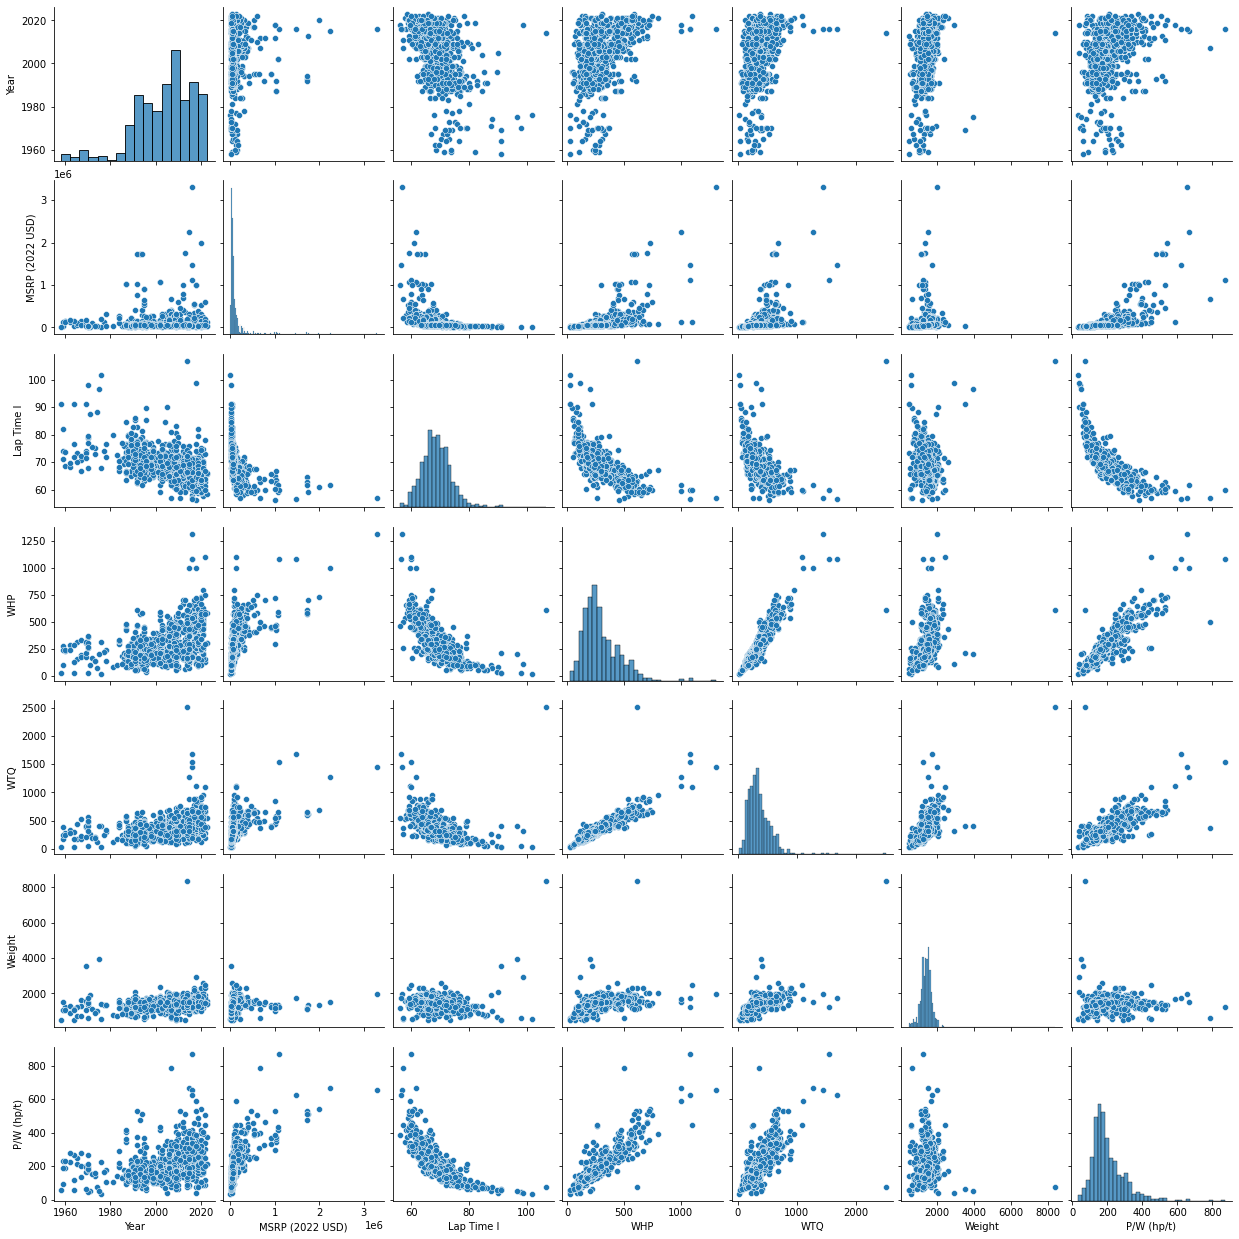

In [13]:
cols = [
'Year',
'MSRP (2022 USD)',
 'Lap Time I',
 'WHP',
 'WTQ',
 'Weight',
 'P/W (hp/t)',]
subsetdf = tsukuba_timed[cols]
sns.pairplot(data = subsetdf)

In [14]:
tsukuba_brand_mu = pd.DataFrame(tsukuba_timed.groupby('Brand').mean())
tsukuba_brand_med = pd.DataFrame(tsukuba_timed.groupby('Brand').median())
display(tsukuba_brand_mu.head())
display(tsukuba_brand_med.head())

,cID,compID,Year,Lap Time I,RC I,Lap Time II,RC II,Lap Time III,RC III,MSRP (2022 USD),WHP,WTQ,Weight,P/W (hp/t),Rating,DR
Brand,,,,,,,,,,,,,,,,
Abarth,4.500000,0.333333,2002.833333,74.355833,0.500000,11.844167,1.0,0.0,NaN,29312.605000,138.833333,201.833333,1022.000000,128.983596,3.300000,3.000000
Acura,13.142857,0.000000,2002.428571,69.718429,0.142857,0.000000,NaN,0.0,NaN,73975.034286,228.000000,242.857143,1361.714286,161.800213,3.142857,2.857143
Alfa Romeo,33.666667,0.000000,1999.000000,70.534778,0.333333,10.881222,1.0,0.0,NaN,96142.977222,230.055556,305.277778,1295.833333,178.803226,3.266667,3.166667
Alpine,58.500000,2.000000,2017.000000,64.742000,0.000000,0.000000,NaN,0.0,NaN,57385.000000,225.000000,303.500000,1095.500000,205.310531,4.500000,2.000000
Ariel,61.000000,0.000000,2009.000000,60.971000,0.000000,0.000000,NaN,0.0,NaN,101467.670000,261.000000,242.000000,595.000000,438.655462,4.000000,0.000000


,cID,compID,Year,Lap Time I,RC I,Lap Time II,RC II,Lap Time III,RC III,MSRP (2022 USD),WHP,WTQ,Weight,P/W (hp/t),Rating,DR
Brand,,,,,,,,,,,,,,,,
Abarth,4.5,0.0,2008.5,71.7840,0.0,0.0,1.0,0.0,NaN,28860.245,155.0,218.0,1058.5,136.025939,3.5,3.0
Acura,13.0,0.0,2002.0,70.5310,0.0,0.0,NaN,0.0,NaN,37293.130,190.0,184.0,1260.0,157.676348,3.5,3.0
Alfa Romeo,34.5,0.0,2005.0,71.1735,0.0,0.0,0.0,0.0,NaN,60531.910,199.0,267.5,1357.5,149.591621,3.5,3.0
Alpine,58.5,2.0,2017.0,64.7420,0.0,0.0,NaN,0.0,NaN,57385.000,225.0,303.5,1095.5,205.310531,4.5,2.0
Ariel,61.0,0.0,2009.0,60.9710,0.0,0.0,NaN,0.0,NaN,101467.670,261.0,242.0,595.0,438.655462,4.0,0.0


In [15]:
subsetdf = subsetdf.assign(pwr= subsetdf['P/W (hp/t)'])
subsetdf = subsetdf.assign(lt= subsetdf['Lap Time I'])
subsetdf['pwr'] = (
    (subsetdf['pwr'] - subsetdf['pwr'].mean())/subsetdf['pwr'].std()
    )
subsetdf['lt'] = (
    (subsetdf['lt'] - subsetdf['lt'].mean())/subsetdf['lt'].std()
    )

pwr = subsetdf['pwr']
lt = subsetdf['lt']
outcome, predictors = patsy.dmatrices('pwr ~ lt', subsetdf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pwr   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     975.4
Date:                Fri, 12 May 2023   Prob (F-statistic):          4.37e-140
Time:                        17:28:17   Log-Likelihood:                -804.87
No. Observations:                 792   AIC:                             1614.
Df Residuals:                     790   BIC:                             1623.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.683e-16      0.024   7.07e-15      1.000      -0.047       0.047
lt            -0.7433      0.024    -31.232      0.000      -0.790      -0.697
==============================================================================
Omnibus:                      517.311   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6954.662
Skew:                           2.779   Prob(JB):                         0.00
Kurtosis:                      16.411   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:ylabel='Frequency'>

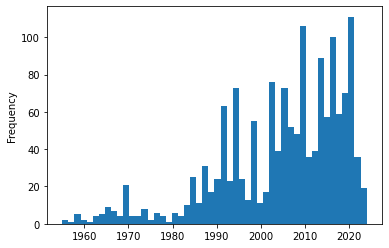

In [16]:
tsukuba.Year.plot(kind="hist", bins=50)

## Baseline Modelling
### Linear Regression

In [35]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Select the specified columns for training and testing
columns = ['Year', 'Brand', 'RC I', 'Country', 'MSRP (2022 USD)', 'WHP', 'WTQ', 'Weight', 'P/W (hp/t)', 'Layout', 'Trans', 'DR', 'Lap Time I']
train_data = tsukuba_all_irl[columns].dropna()
test_data = tsukuba_test_set_irl[columns].dropna()

# Split the data into features and target
X_train = train_data.drop('Lap Time I', axis=1)
y_train = train_data['Lap Time I']
X_test = test_data.drop('Lap Time I', axis=1)
y_test = test_data['Lap Time I']

# Preprocessing steps for numerical and categorical features
numeric_features = ['Year', 'MSRP (2022 USD)', 'WHP', 'WTQ', 'Weight', 'P/W (hp/t)']
categorical_features = ['Brand', 'Country', 'Layout', 'Trans', 'DR']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the linear regression model
linear_regression_model_all = LinearRegression()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', linear_regression_model_all)
])

# Train the linear regression model on all real-life cars
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for LReg model trained on all real life data including cars in the test set:", rmse)

RMSE for LReg model trained on all real life data including cars in the test set: 1.8574028042110606


In [30]:
tsukuba_all_irl.isnull().sum()

cID                  0
compID               0
Year                 0
Brand                0
Model                0
Lap Time I           0
RC I                 2
Tire II            338
Lap Time II          0
RC II              338
Tire III           340
Lap Time III         0
RC III             340
Country              0
MSRP (2022 USD)     68
WHP                  0
WTQ                  0
Weight               0
P/W (hp/t)           0
Layout               0
Trans                0
Rating             338
DR                   0
_HD                  0
Source               0
dtype: int64